In [1]:
import torch
print("torch module path:", torch.__file__)
print(torch.cuda.is_available())
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, log_loss

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from collections import Counter
from sklearn.preprocessing import StandardScaler


torch module path: c:\Users\Daria\anaconda3\Lib\site-packages\torch\__init__.py
False


In [2]:
#try different optimizer
#try transformer
#NN without dropout/patience

In [3]:

data = pd.read_csv('Data/Final_data/final_depr_one_scaled_2')

data = data.iloc[:, 1:]
data.head()

,821,328813,823,817,818,239935,28116,351091,28118,1161942,...,78344,1692,68274,40091,1393,28133,183,29346,349096,Depression
0,0.224972,0.002162,0.001842,0.000801,0.002563,0.000080,0.038603,0.002723,0.002403,0.000000,...,0.0,0.0,0.0,0.00008,0.0,0.0,0.0,0.000000,0.00008,0
1,0.009963,0.000082,0.018865,0.000082,0.003022,0.005063,0.006370,0.018375,0.000408,0.034953,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.00000,1
2,0.131690,0.018601,0.000093,0.005562,0.013163,0.009362,0.215486,0.009795,0.002101,0.000185,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000031,0.00000,0
3,0.106448,0.003627,0.002877,0.000375,0.021202,0.000063,0.039402,0.060479,0.000751,0.000125,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.00000,0
4,0.175204,0.003135,0.010005,0.003919,0.018581,0.020932,0.045184,0.012679,0.004611,0.002674,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.00000,1


In [4]:
class Model(nn.Module):
    def __init__(self, input_size, h1, h2, h3, output_size = 2):
        super(Model, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, h1),
            nn.ReLU(),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Linear(h2, h3),
            nn.ReLU(),
            nn.Linear(h3, output_size) 
        )
    def forward(self, x):
        return self.net(x)


In [5]:
class SklearnWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_size=10, h1=32, h2=16, h3=16, lr=0.01, num_epochs=100):
        self.input_size = input_size
        self.h1 = h1
        self.h2 = h2
        self.h3 = h3
        self.lr = lr
        self.num_epochs = num_epochs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None

    def fit(self, X, y):
        dataset = TensorDataset(X, y)
        
        #val_size = int(0.2 * len(dataset))
        #train_size = len(dataset) - val_size
        #train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
        #val_loader = DataLoader(val_dataset, batch_size=32)

        self.model = Model(self.input_size, self.h1, self.h2, self.h3).to(self.device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()


        for epoch in range(self.num_epochs):
            self.model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                pred = self.model(xb)
                loss = criterion(pred, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


        return self


    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X)
        return outputs.argmax(dim=1).cpu().numpy()
    
    def predict_proba(self, X):
        with torch.no_grad():
            outputs = self.model(X)
            probs = torch.softmax(outputs, dim=1)
            return probs.cpu().numpy()


In [6]:
'''param_grid = {
    'h1': [32, 64],
    'h2': [16, 32],
    'h3': [16, 32],
    'lr': [0.0001],
    'num_epochs': [100 ]
}'''

"param_grid = {\n    'h1': [32, 64],\n    'h2': [16, 32],\n    'h3': [16, 32],\n    'lr': [0.0001],\n    'num_epochs': [100 ]\n}"

In [7]:
param_grid = {
    'h1': [32, 64, 96, 128, 160],
    'h2': [16, 32, 64, 96],
    'h3': [16, 32, 64, 96],
    'lr': [0.0001, 0.0005],
    'num_epochs': [40, 60, 100, 120, 160, 200]
}

In [8]:
X = data.drop('Depression', axis = 1)
y = data['Depression']

X = X.values
y = y.values


In [9]:

nested_scores = []
data_X = data.drop('Depression', axis = 1)
feature_names = data_X.columns.tolist()
N = 60
all_fprs = []
all_tprs = []
roc_auc_scores = []
top_features_per_fold = []

outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in outer_cv.split(X, y):
    X_train_cv = X[train_idx]
    y_train_cv = y[train_idx]
    X_test_cv = X[test_idx]
    y_test_cv = y[test_idx]

    scaler = StandardScaler()
    X_train_cv = scaler.fit_transform(X_train_cv)
    X_test_cv = scaler.fit_transform(X_test_cv)

    X_train_cv = torch.FloatTensor(X_train_cv)
    y_train_cv = torch.LongTensor(y_train_cv)
    X_test_cv = torch.FloatTensor(X_test_cv)
    


    clf = GridSearchCV(SklearnWrapper(input_size=X.shape[1]), param_grid, cv=3, scoring='accuracy') #, n_jobs=-1
    clf.fit(X_train_cv, y_train_cv)

    with torch.no_grad():
        first_layer_weights = clf.best_estimator_.model.net[0].weight.detach().cpu().numpy()
        feature_importance = np.mean(np.abs(first_layer_weights), axis=0)
        top_feature_indices = np.argsort(feature_importance)[::-1][:N]
        top_feature_names = [feature_names[i] for i in top_feature_indices]

    #print("Top feature indices:", top_feature_indices)
    print("Top feature names:", top_feature_names)
    top_features_per_fold.append(top_feature_names)   

    preds = clf.predict(X_test_cv)
    acc = accuracy_score(y_test_cv, preds)
    nested_scores.append(acc)
    print(f"Fold Accuracy: {acc:.4f}")

    cm = confusion_matrix(y_test_cv, preds)
    print("Confusion Matrix:")
    print(cm)

    
    if hasattr(clf, "predict_proba"):
        probs = clf.predict_proba(X_test_cv)[:, 1]
        roc_auc = roc_auc_score(y_test_cv, probs)
        print(f"ROC AUC Score: {roc_auc:.4f}")
        roc_auc_scores.append(roc_auc)

        fpr, tpr, _ = roc_curve(y_test_cv, probs)
        all_fprs.append(fpr)
        all_tprs.append(tpr)
    else:
        print("ROC AUC Score: Not available (no probability prediction)")

print(f"Nested CV Mean Accuracy: {np.mean(nested_scores):.4f}")


Top feature names: ['36854', '392736', '544645', '255723', '1692', '947013', '204038', '587', '360807', '183', '66219', '29346', '1646377', '658457', '584', '1536', '53462', '202611', '40324', '138595', '831', '46503', '1670', '1453594', '85831', '46206', '216940', '1495', '47246', '1343', '1623', '52769', '28134', '36842', '999468', '1503', '46506', '301302', '1352', '47884', '40091', '2137', '1736', '2088', '45254', '363832', '103892', '68274', '1530', '376805', '562', '339862', '78344', '574930', '1309', '264027', '1322', '148814', '66851', '52226']
Fold Accuracy: 0.9425
Confusion Matrix:
[[41  2]
 [ 3 41]]
ROC AUC Score: 0.9709
Top feature names: ['255723', '40091', '66219', '339862', '183', '376805', '45076', '1692', '29346', '1015', '147802', '36842', '947013', '1304158', '2137', '392736', '1309', '85831', '78344', '314319', '97253', '395922', '106648', '745368', '28134', '310298', '736', '1453594', '1736', '1586267', '148814', '89014', '36854', '167964', '46867', '1495', '397865

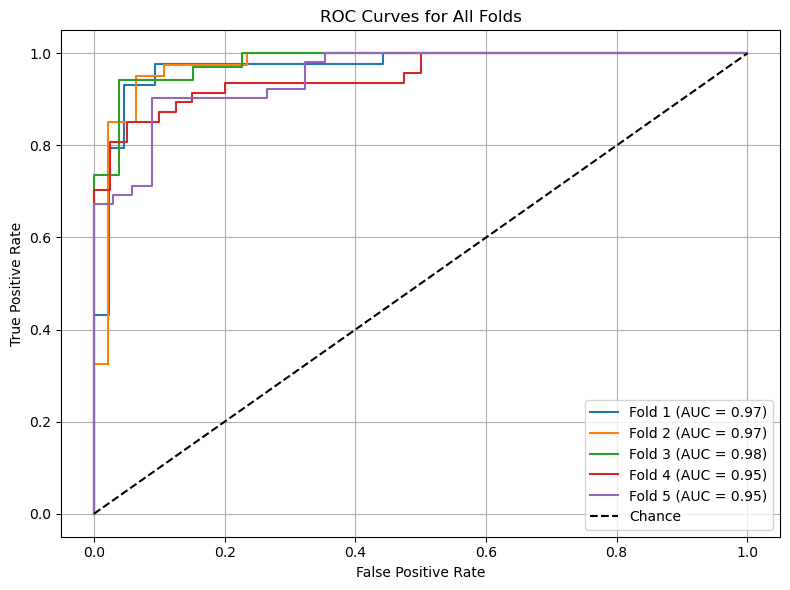

In [10]:
plt.figure(figsize=(8, 6))
for i in range(len(all_fprs)):
    plt.plot(all_fprs[i], all_tprs[i], label=f'Fold {i+1} (AUC = {roc_auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Folds')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
print(clf.best_estimator_.model)

Model(
  (net): Sequential(
    (0): Linear(in_features=556, out_features=96, bias=True)
    (1): ReLU()
    (2): Linear(in_features=96, out_features=96, bias=True)
    (3): ReLU()
    (4): Linear(in_features=96, out_features=96, bias=True)
    (5): ReLU()
    (6): Linear(in_features=96, out_features=2, bias=True)
  )
)


In [12]:
def features_in_k_arrays(arrays, k):
    if not arrays:
        return []

    counter = Counter()
    
    for array in arrays:
        unique_strings = set(array)  
        counter.update(unique_strings)
    
    return [string for string, count in counter.items() if count >= k]

In [13]:

k=5
common_features = features_in_k_arrays(top_features_per_fold, k)
print(f"\nFeatures appearing in at least {k} folds: {common_features} \n total length: {len(common_features)}")
k=4
common_features = features_in_k_arrays(top_features_per_fold, k)
print(f"\nFeatures appearing in at least {k} folds: {common_features} \n total length: {len(common_features)}")

k=3
common_features = features_in_k_arrays(top_features_per_fold, k)
print(f"\nFeatures appearing in at least {k} folds: {common_features} \n total length: {len(common_features)}")



Features appearing in at least 5 folds: ['831', '339862', '376805', '66219', '947013', '78344', '40091', '36842', '36854', '392736', '1495', '1692', '1736'] 
 total length: 13

Features appearing in at least 4 folds: ['85831', '831', '339862', '376805', '66219', '148814', '947013', '78344', '40091', '36842', '28134', '36854', '183', '392736', '1343', '1309', '1495', '255723', '1692', '1736', '1530', '1586267', '1304158', '1776082', '45076', '232270'] 
 total length: 26

Features appearing in at least 3 folds: ['68274', '53462', '85831', '831', '339862', '47246', '376805', '1670', '66219', '148814', '947013', '78344', '2137', '40091', '36842', '28134', '36854', '183', '392736', '1343', '1309', '363832', '29346', '1495', '216940', '255723', '1692', '1736', '1530', '1453594', '1586267', '46867', '1304158', '1776082', '45076', '310298', '232270', '28133', '745368', '47877', '863'] 
 total length: 41


In [14]:
best_model = clf.best_estimator_